# Ordinary and Simple Kriging - tutorial

## Table of Contents:

1. Read point data,
2. Set semivariogram model,
3. Set Ordinary Kriging and Simple Kriging models,
4. Predict values at unknown locations.

## Level: Basic

## Introduction

In this tutorial we will learn how to perform prediction with Ordinary and Simple Kriging. We will compare different number of ranges and test outcomes of processing with root mean squared error.

Ordinary and Simple Kriging are the simplest form of Kriging. After this tutorial you may learn how to perform Point Poisson Kriging (based on the centroid values) which is a form of areal kriging.

We use DEM data which is stored in a file 'sample_data/poland_dem_gorzow_wielkopolski'.

## Import packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pyinterpolate import read_point_data
from pyinterpolate import calculate_semivariance  # experimental semivariogram
from pyinterpolate import fit_semivariance  # theoretical models
from pyinterpolate import point_kriging  # kriging models

## 1) Read point data

In [2]:
dem = read_point_data('../sample_data/poland_dem_gorzow_wielkopolski', data_type='txt')

In [3]:
# Remove 40% of rows (values) to test our model

def create_train_test(dataset: np.array, frac=0.2):
    """
    Function divides base dataset into a training and a test set
    
    INPUT:
    :param dataset: (numpy array) array with rows of records,
    :param frac: (float) number of elements in a test set
    
    OUTPUT:
    return: training_set (numpy array), test_set (numpy array)
    """

    removed_idx = np.random.randint(0, len(dem)-1, size=int(frac * len(dem)))
    test_set = dem[removed_idx]
    training_set = np.delete(dem, removed_idx, 0)
    return training_set, test_set    

train_set, test_set = create_train_test(dem, frac=0.4)

### Clarification:

We remove subset of points from a dataset to be sure that Kriging is working. In this scenario 40% of available points are removed, but in a real-world cases you will probably have even less points to perform estimations, down to the 1% of known values.

Function **create_train_test()** divides our dataset into two subsets:
- training set used for semivariogram model derivation,
- test set used for the model error calculation.

Points for each set are chosen randomly to avoid bias related to the geographical location. Let's imagine that you have a sorted list of Digital Elevation Model points. Western part of your measurements covers a mountain and Eastern part is a plain. Then you take western part for semivariogram modeling and eastern part for test. It ends with catastrophe because your semivariogram learns that elevation is changing over a distance but it is not true in the East!

## 2) Set Semivariogram model

More about semivariogram modeling in tutorial about Semivariogram calculation: [url]

In [4]:
# Create experimental semivariogram

# Prepare experimental semivariogram

search_radius = 0.01
max_range = 0.32
data_lags = np.arange(0, max_range, search_radius * 2)

exp_semivar = calculate_semivariance.calculate_semivariance(data=train_set, 
                                                            lags=data_lags, 
                                                            step_size=search_radius)

100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


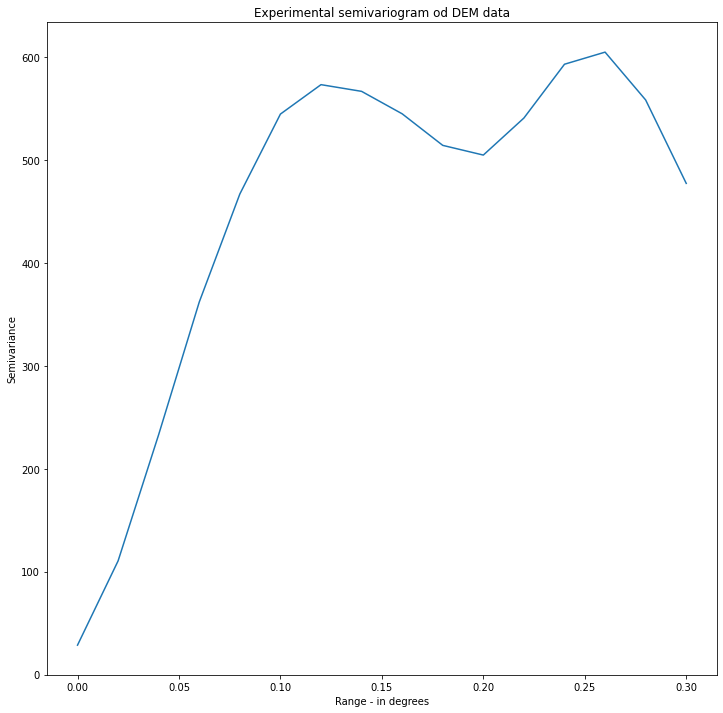

In [5]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od DEM data')
plt.xlabel('Range - in degrees')
plt.ylabel('Semivariance')
plt.show()

In [6]:
# Fit different semivariogram models into experimental data

semivar = fit_semivariance.TheoreticalSemivariogram(points_array=train_set,
                                                          empirical_semivariance=exp_semivar)
number_of_ranges = len(data_lags)  # The same number of ranges as experimental semivariogram

semivar.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

Model: spherical, error value: 36.637334280295114
Model: exponential, error value: 53.96048358462277
Model: linear, error value: 36.41159497236879
Chosen model: linear, with value: 36.41159497236879.


'linear'

## 3) Set Ordinary Kriging and Simple Kriging models

This is the most important step of our tutorial. We've set our semivariogram model and now we are able to perform prediction of an unknown values. In a first try we will "predict" known, arbitrary point and in the second step we will try to guess values at unknown locations and calculate RMSE of those values.

For both kriging types class is the same **Kriging**. It takes as arguments theoretical semivariogram model **TheoreticalSemivariogram** class instance and known data points as the Numpy array.

In [7]:
# Set Kriging model

model = point_kriging.Krige(semivariogram_model=semivar, known_points=train_set)

In [8]:
# Get one value for prediction:

known_val = train_set[10]
print(known_val)

[15.11563642 52.70180578 39.36869049]


In [9]:
# Now make predictions

# First - ordinary kriging

ok_pred = model.ordinary_kriging(unknown_location=known_val[:-1],
                                 number_of_neighbours=16)

# Second - simple kriging

sk_pred = model.simple_kriging(unknown_location=known_val[:-1],
                              number_of_neighbours=16,
                              mu=np.mean(dem[:, -1]))

print('Ordinary Kriging:\n')
print(ok_pred)
print('')
print('========== ========== ========== ========== ==========')
print('')
print('Simple Kriging:\n')
print(sk_pred)

Ordinary Kriging:

(39.368690490722656, 5.344013654234511, -2.9398390046069194e-16, array([ 1.00000000e+00, -1.52490110e-17, -2.17595612e-16,  7.05913985e-17,
       -4.66832346e-17,  9.74659811e-17, -7.31782219e-17,  3.68803644e-18,
       -3.22806204e-16,  9.98151180e-18,  2.03831221e-16,  3.80178852e-18,
        1.86751336e-16,  5.14013165e-18, -1.38249025e-16,  8.24161943e-17,
       -2.93983900e-16]))

========== ========== ========== ========== ==========

Simple Kriging:

(39.368690490722656, 5.344013654234511, 40.9509380348875, array([ 1.00000000e+00,  7.83064125e-18, -4.88008159e-16,  2.34280129e-16,
       -5.23957016e-18,  7.73240995e-17, -9.35900453e-18,  5.02770152e-17,
        3.52138297e-17,  2.05075579e-18, -2.00638390e-17,  6.93610927e-18,
       -5.59092841e-18, -8.48265973e-18, -1.72561312e-17, -2.59067850e-17]))


In [10]:
print('Difference between real value and OK:')
print(int(known_val[-1] - ok_pred[0]))

Difference between real value and OK:
0


In [11]:
print('Difference between real value and SK:')
print(int(known_val[-1] - sk_pred[0]))

Difference between real value and SK:
0


### Clarfication:

What has just happened?

We go through each cell to understand what our Kriging has done.

1. Set the Kriging model. Our Krige class is in fact a container for theoretical semivariogram model and known points in our dataset. At this stage it is method agnostic and it doesn't matter if you'd like to perform Ordinary or Simple Kriging.
2. In the next cell we take one arbitrary value from known points list.
3. Then we perform Ordinary and Simple Kriging. Both methods have similar arguments but Simple Kriging requires additional piece of information: mean of the process. If you don't know the mean then Simple Kriging derives it as a sample mean from the known values (WARNING: this is not recommended, in the future versions of library this process will invoke Warning). If you do not know a process mean it is good idea to leave Simple Kriging and choose Ordinary Kriging instead.
4. Both methods return four objects. The first one is predicted value, then estimated error standard deviation, estimated mean (ordinary kriging) / mean (simple kriging) and weights matrix.
5. Then we calculate difference between predicted and real values. As you may notice difference between Kriging prediction and real value is 0 (due to the floating point precision it may be extremly close to 0 if we left floats).

## 4) Predict values at unknown locations

Only one parameter is directly controlled by us and it is number of neighbors used for prediction. We can test optimal number of them with a test set leaved for further analysis.

We create simple function which chooses the most promising ordinary kriging and simple kriging model based on the root mean squared error of predictions.

In [12]:
def test_ordinary_kriging(kriging_model, test_values, number_of_neighbors):
    
    mse_arr = []
    for x in test_values:
        prediction = kriging_model.ordinary_kriging(
            x[:-1],
            number_of_neighbours=number_of_neighbors)
        predicted = prediction[0]
        mse = (x[-1] - predicted)**2
        mse_arr.append(mse)
    rmse = np.sqrt(np.mean(mse))
    return rmse

In [13]:
# Number of neighbors

no_of_n = [4, 8, 16, 32, 64]

for nn in no_of_n:
    print('Number of neighbors:', nn)
    rmse_pred = test_ordinary_kriging(kriging_model=model,
                                      test_values=test_set,
                                      number_of_neighbors=nn)
    print('RMSE:', rmse_pred)
    print('')

Number of neighbors: 4
RMSE: 1.391183170538497

Number of neighbors: 8
RMSE: 1.3918025417715398

Number of neighbors: 16
RMSE: 1.4436767936386445

Number of neighbors: 32
RMSE: 1.4350323944256331

Number of neighbors: 64
RMSE: 1.3977706453860321



### Clarification:

Now we perform practical test of usefulness of our algorithm. The idea is to use our test set, predict values "not seen" by the kriging algorithm and compare prediction to the ground truth value. Then we calculate root of a mean squared errors between real values and predictions.

We can find the best **number_of_neighbors** parameter, or alternatively we can discover how many closest points influence our point. More doesn't better as you can see in this realization.

**NOTE:**

1. This is only a single realization of a division between variables. RMSE of single experiment is not reliable from the practical perspective, you should divide dataset randomly multiple times to find the best number of neighbors for the analysis.
2. RMSE value is used in this approach because it is a very good indicator of outliers in data. You should consider simple difference if you want to know if your kriging overestimates values (negative mean differences) or underestimates them (positive mean differences). There are other techniques to measure predictions error.

In [14]:
def test_simple_kriging(kriging_model, test_values, number_of_neighbors, mean_areal):
    
    mse_arr = []
    for x in test_values:
        prediction = kriging_model.simple_kriging(
            x[:-1],
            number_of_neighbours=number_of_neighbors,
            mu=mean_areal
        )
        predicted = prediction[0]
        mse = (x[-1] - predicted)**2
        mse_arr.append(mse)
    rmse = np.sqrt(np.mean(mse))
    return rmse

In [15]:
# Number of neighbors

no_of_n = [4, 8, 16, 32, 64]

for nn in no_of_n:
    print('Number of neighbors:', nn)
    rmse_pred = test_simple_kriging(kriging_model=model,
                                      test_values=test_set,
                                      number_of_neighbors=nn,
                                      mean_areal=np.mean(dem[:, -1]))
    print('RMSE:', rmse_pred)
    print('')

Number of neighbors: 4
RMSE: 1.2830600067123896

Number of neighbors: 8
RMSE: 1.7590161040743197

Number of neighbors: 16
RMSE: 1.7367892240800131

Number of neighbors: 32
RMSE: 1.5428259478570823

Number of neighbors: 64
RMSE: 1.447766539555758



### Clarification:

Usually Simple Kriging will give you worse results than Ordinary Kriging. Especially if you do not know process mean. What is more important: Simple Kriging returned best results for the same number of neighbors as Ordinary Kriging. That's why it is good idea to compare both techniques if you have such opportunity (process mean, or known-points sample mean if you like a risk). Data division for test and train set may influence Simple Kriging results and for some realizations RMSE will be very low but for the others it is extremely large.